In [38]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing.imputation import Imputer
from sklearn import datasets
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm

baseball_file_path = '/Users/HuanLiang/Desktop/Winning and Baseball/MLB Data v6.csv'
baseball_data = pd.read_csv(baseball_file_path)

# Introduction
This is the extension of the "winning and revenue in the MLB" project that I completed in Sports Analytics class. Unlike my analysis in R, I'd like to try to use monetary and performance variables to predict whether a baseball team will make the playoffs in the following season in Python. 

## Inductive Model
First, we take a look at the data and see what variables make the most sense in predicting revenue. I believe it is important to get an intuitive sense of which factors play the largest role before preforming any visualizations or that sort. What variables make sense in predicting the success of a baseball team in the previous year?

In [39]:
baseball_vars = ['real_revenue_2016', 'W', 'Total_Attendance', 'per_capita_income', 'RS_total', 
                     'stadium_age', 'post_season_appearance', 'postseason_nextyear',
                     'RA_total']
baseball_pred_data = baseball_data[baseball_vars]
y = baseball_pred_data.postseason_nextyear
predictors = ['real_revenue_2016', 'W', 'Total_Attendance', 'per_capita_income', 'RS_total', 
                     'stadium_age', 'post_season_appearance',
                     'RA_total']
X = baseball_data[predictors]

In [40]:
baseball_pred_data.describe()

,real_revenue_2016,W,Total_Attendance,per_capita_income,RS_total,stadium_age,post_season_appearance,postseason_nextyear,RA_total
count,6.980000e+02,698.000000,6.980000e+02,698.000000,698.00000,698.000000,698.000000,698.000000,698.000000
mean,1.209168e+08,79.746418,2.398896e+06,40820.861676,740.82235,27.229226,0.256447,0.262178,740.085960
std,5.707538e+07,12.264196,7.074398e+05,11233.024234,92.86965,25.461968,0.436985,0.440134,97.410952
min,3.005903e+07,43.000000,8.131270e+05,21903.000000,466.00000,1.000000,0.000000,0.000000,448.000000
25%,7.879968e+07,71.000000,1.821472e+06,32214.000000,679.00000,9.000000,0.000000,0.000000,674.000000
50%,1.079515e+08,80.000000,2.352582e+06,40117.850000,739.50000,19.000000,0.000000,0.000000,739.000000
75%,1.515427e+08,89.000000,2.949038e+06,48017.250000,801.00000,36.000000,1.000000,1.000000,807.500000
max,4.274713e+08,116.000000,4.446678e+06,84675.000000,1009.00000,105.000000,1.000000,1.000000,1103.000000


## Data exploration
These are the main variables that we will be working with, at least for now. There are eight predictors that will predict a team's postseason potential the following season. Let's take a look at these variables closer.

In [41]:
y.value_counts()

0    515
1    183
Name: postseason_nextyear, dtype: int64

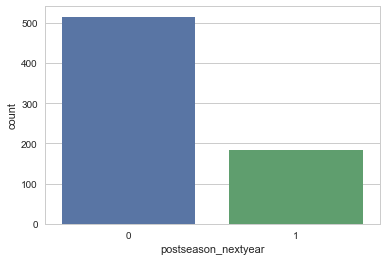

In [42]:
sns.countplot(x = y,)
plt.show()

As expected, there are more than twice number of teams that failed to make the playoffs as opposed to number of teams that did make the playoffs. Of course, out of about thirty teams in the MLB each season, only eight teams make the playoffs. Now, what is so special about these teams? Let's take a look by grouping the data based on our dependent variable.

In [43]:
baseball_pred_data.groupby('postseason_nextyear').mean()

,real_revenue_2016,W,Total_Attendance,per_capita_income,RS_total,stadium_age,post_season_appearance,RA_total
postseason_nextyear,,,,,,,,
0,1.123147e+08,77.695146,2.292807e+06,40482.961223,731.058252,24.809709,0.182524,751.007767
1,1.451247e+08,85.519126,2.697451e+06,41771.783716,768.300546,34.038251,0.464481,709.349727


In [44]:
baseball_pred_data.groupby('postseason_nextyear').median()

,real_revenue_2016,W,Total_Attendance,per_capita_income,RS_total,stadium_age,post_season_appearance,RA_total
postseason_nextyear,,,,,,,,
0,102145267.3,78,2249201,39870.0,730,17,0,751
1,138675492.9,87,2776531,42006.0,772,25,0,705


Wow! The mean and the median show similar insights. For example, teams that made the playoffs in the following season had higher revenue, more wins, more attendance, higher income, scored more runs and had fewer runs scored against the team. The stadium age seems a big odd, as teams with older stadiums seem to make the playoffs in the following season more often.  

If I build the function here for the decision tree regressor, it will be easier to use in later cases as well. Let's see how this model performs, by using mean absolute error and root mean squared error. Since we only have less than 700 data points, cross validation is used so the errors are affected by noise to a smaller degree. Now, let's create some graphs to explore the data more in detail

## Data Visualization

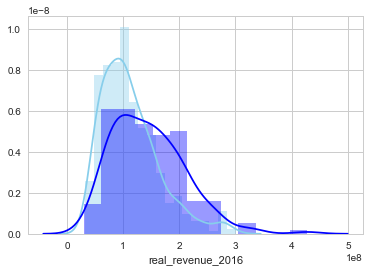

In [45]:
sns.distplot(baseball_pred_data.real_revenue_2016.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.real_revenue_2016.loc[y == 1], color="blue")

I believe that using seaborn's histograms allows me to learn how the data is distributed. Looking at revenue alone, teams with playoff teams are shifted to the right in the revenue axis. There is also a more even spread in the dark blue distribution.

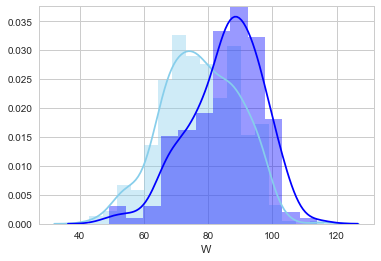

In [46]:
sns.distplot(baseball_pred_data.W.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.W.loc[y == 1], color="blue")

This shift is much more apparent, and rightfully so. Success of a team often transfers to the following year.

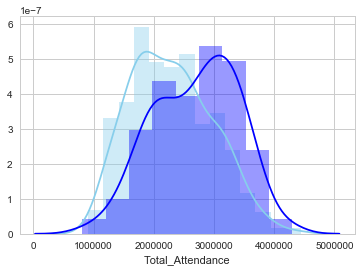

In [47]:
sns.distplot(baseball_pred_data.Total_Attendance.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.Total_Attendance.loc[y == 1], color="blue")

More people show up to successful team's game, but the size of the stadium is factored into this. 

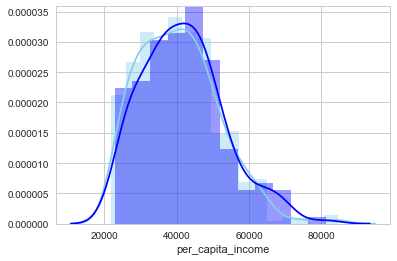

In [48]:
sns.distplot(baseball_pred_data.per_capita_income.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.per_capita_income.loc[y == 1], color="blue")

This I find extremely interesting. I would think that teams in wealthier areas pay more for tickets and the teams are richer as a result. Can't richer teams afford to buy better players?

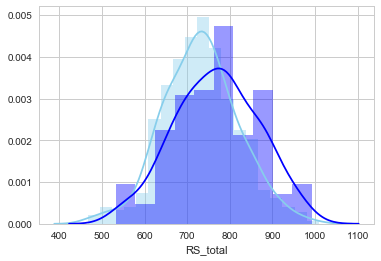

In [49]:
sns.distplot(baseball_pred_data.RS_total.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.RS_total.loc[y == 1], color="blue")

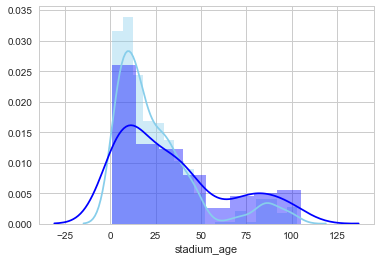

In [50]:
sns.distplot(baseball_pred_data.stadium_age.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.stadium_age.loc[y == 1], color="blue")

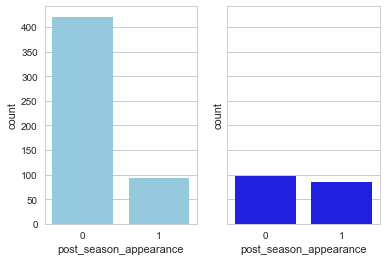

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.countplot(baseball_pred_data.post_season_appearance.loc[y == 0], ax = ax1, color="skyblue")
sns.countplot(baseball_pred_data.post_season_appearance.loc[y == 1], ax = ax2, color="blue")

This is also surprising. I would think that more teams that made the playoffs the previous year would make it the following the year, but the numbers are about even.

## Model Building

Since the only categorical variable is post_season_appeance, and the data was already transformed when the data was loaded on to pandas. I'm going to try this "Recursive Feature Elimination" method that gets rid of my unwanted variables. I'm not too sure how it works or if it is necessary in this case. 

In [52]:
logreg = LogisticRegression()
rfe = RFE(logreg, 1)
rfe = rfe.fit(X, y)
print(rfe.ranking_)



[6 1 5 4 3 7 8 2]


To be honest, this doesn't tell me much. I can choose the top 3 or 4 or 5 or whatever, but what is that magic number?

In [53]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.502253
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit                No. Iterations:    6.0000  
Dependent Variable:   postseason_nextyear  Pseudo R-squared:  0.127   
Date:                 2018-09-19 20:38     AIC:               717.1457
No. Observations:     698                  BIC:               753.5314
Df Model:             7                    Log-Likelihood:    -350.57 
Df Residuals:         690                  LL-Null:           -401.58 
Converged:            1.0000               Scale:             1.0000  
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
real_revenue_2016       0.0000   0.0000  0.7386 0.4602 -0.0000  0.0000
W                      -0.0268   0.0142 -1.8938 0.0583 -0.0546  0.0009
Total_Attendance        0.0000   0.0000  1.0109 0.3121 -0.0000  0.0000
per_capita_income      -0.0000   0.0000 -0.0126 0.9899 -0.0000  0.0000
RS_total                0.0074   0.0022  3.4508 0.0006  0.0032  0.0117
stadium_age             0.0074   0.0036  2.0476 0.0406  0.0003  0.0145
post_season_appearance  0.4854   0.2629  1.8463 0.0648 -0.0299  1.0007
RA_total               -0.0080   0.0015 -5.4469 0.0000 -0.0108 -0.0051
======================================================================

"""

Wow, some interesting p values here. For per capita income, I would think that it has nothing to do with playoff chance because we saw the histogram above and the two were too similar. However, for revenue, I did not expect the p value to be that big. You'd think that with more revenue, a team is able to buy more players, and as a result, create better chances to make the playoffs. 

Anyway, let's keep the variables where the p-value is below $0.1$ for now and create our logistic regression model.

In [54]:
new_vars = ['W', 'RS_total', 'stadium_age', 'post_season_appearance', 'RA_total']
X1 = baseball_data[new_vars]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3, random_state = 0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


Honestly, this is better than I thought. However, the amount of data that we have is small. The score that we got could literally be from noise. It should be beneficial to cross validate our model.

In [56]:
kfold = model_selection.KFold(n_splits=5, random_state=0)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring='accuracy')
print("5-fold cross validation average accuracy: %.3f" % (results.mean()))

5-fold cross validation average accuracy: 0.754


Since the train test split and the cross validation score are similar, we can assume that our model generalizes pretty well.

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[152   9]
 [ 41   8]]


Out of the $210$ predictions, $160$ was correct while $50$ was incorrect. 152 no playoff teams were correctly predicted, while 8 playoff teams were predicted correctly. 9 teams were p

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.94      0.86       161
          1       0.47      0.16      0.24        49

avg / total       0.71      0.76      0.71       210



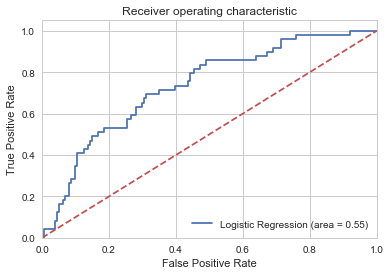

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Now, let's try other classification models and see how they compare with logistic regression.

In [71]:
def run_model(model, alg_name, plot_index):
    # build the model on training data
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    # calculate the accuracy score
    accuracy =  accuracy_score(y_test, y_pred) * 100
    return accuracy

#     # Compare the prediction result with ground truth
#     color_code = {'Iris-virginica':'red', 'Iris-setosa':'blue', 'Iris-versicolor':'green'}

#     plt.figure(plot_index)
#     ax = fig.add_subplot(4,2,plot_index) 
#     colors = [color_code[x] for x in y_test.iloc[:,0]]
#     ax.scatter(X_test.iloc[:,0], X_test.iloc[:,3], color=colors, marker='.', label='Circle = Ground truth')
#     colors = [color_code[x] for x in y_pred]
#     ax.scatter(X_test.iloc[:, 0], X_test.iloc[:,3], color=colors, marker='o', facecolors='none', label='Dot = Prediction')

#     #plt.axes([0.65, 0.65, 0.2, 0.2])
#     ax.legend(loc="lower right")
#     # manually set legend color to black
#     leg = plt.gca().get_legend()
#     leg.legendHandles[0].set_color('black')
#     leg.legendHandles[1].set_color('black')
#     leg.legendHandles[1].set_facecolors('none')

#     ax.set_title(alg_name + ". Accuracy: " + str(accuracy))

In [75]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
print(run_model(model, "Random Forest", 2))

from xgboost import XGBClassifier

model = XGBClassifier()
print(run_model(model, "XGBoost", 3))

# ------ SVM Classifier ----------------
from sklearn.svm import SVC
model = SVC()
print(run_model(model, "SVM Classifier", 4))

# -------- Nearest Neighbors ----------
from sklearn import neighbors
model = neighbors.KNeighborsClassifier()
print(run_model(model, "Nearest Neighbors Classifier", 5))

# ---------- SGD Classifier -----------------
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(SGDClassifier())
print(run_model(model, "SGD Classifier", 6))

# --------- Gaussian Naive Bayes ---------
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
print(run_model(model, "Gaussian Naive Bayes", 7))

# ----------- Neural network - Multi-layer Perceptron  ------------
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
print(run_model(model, " MLP Neural network ", 8))

76.19047619047619
72.38095238095238
76.66666666666667
74.28571428571429
76.66666666666667
75.71428571428571
76.66666666666667


/Users/HuanLiang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/HuanLiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


The mean absolute error derived from cross validation is about twenty percent of revenue means. Currently, I am unsure if this is good or bad. Now, it's time to try a decision tree regressor. Since the forest takes the average of many trees, I hope my mean average error will be smaller. Again, I will write a function.

In [176]:
def randomforest(X, y):
    l = []
    for i in range(5):
        model2 = RandomForestRegressor(random_state = i)
        model2.fit(X, y)
        preds = model2.predict(X)
        mae_scores = cross_val_score(model2, X, y, scoring='neg_mean_absolute_error', cv = 5)
        l.append(-1 * mae_scores.mean())
    return min(l)

randomforest(X,y)
    
    

18579631.15197081

I mean, sure it is smaller, but nearly twenty million is still quite large. Now, instead of getting rid of null values, I will use imputation as an alternative. 

In [177]:
y1 = baseball_pred_data.real_revenue_2016
y1 = y1.fillna(y1.mean())
X1 = baseball_pred_data[revenue_preds]

imputer = Imputer()
X1 = imputer.fit_transform(X1)

In [139]:
print(np.isnan(y1).sum())

0


In [178]:
print(randomforest(X1, y1))
print(decisiontree(X1, y1))

18743983.235965025
24364527.053714447


Interestingly, using the imputer to compute the missing values creates no smaller mean average error. Another powerful technique that I have googled is the XGBoost technique. While I have much to learn about that, I will use it here.

In [179]:
def xgbooster(X, y):
    model3 = XGBRegressor(learning_rate = 0.04)
    model3.fit(X, y,  verbose = False)
    preds = model3.predict(X)
    mae_scores = cross_val_score(model3, X, y, scoring='neg_mean_absolute_error', cv = 5)
    return (-1 * mae_scores.mean())

xgbooster(X,y)

17006527.167371903